# Random Forest Regressor for UQ

## Import Libraries

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy.stats import norm
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)

from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt  

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

#imported to hide tensorflow & plot warnings
import warnings
warnings.filterwarnings('ignore')

#import to compute and visualize metrics
import uncertainty_toolbox as uct

2022-08-18 16:37:12.329004: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-18 16:37:12.334072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 16:37:12.334083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load & Preprocess data

In [2]:
data = pd.read_excel("../../../Data/dense_data.xlsx")
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])
X_encoded = preprocessor.fit_transform(X)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2)
perc = "{0:.0%}".format(len(X_train)/len(X_encoded))
print(f"X_train : {len(X_train)} ({perc})  |  X_test : {len(X_test)}  ")

X_train : 5851 (80%)  |  X_test : 1463  


## Model

In [4]:
#get mode instance
nb_estim = 80
model = RandomForestRegressor(n_estimators = nb_estim, max_depth = 26, random_state = 18)

#train model
model.fit(X_train, y_train)

#get predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [5]:
#get generated models from RF
list_model = [mm for mm in model.estimators_]
def get_predictions(list_model, X):
    """
    Recover and store all predictions 
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    res = np.empty((X.shape[0],1, len(list_model)))
    for ii, model_i in enumerate(list_model):
        pred_i = model_i.predict(X)
        res[:,:,ii] = pred_i[...,np.newaxis]
    return res

## Results

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

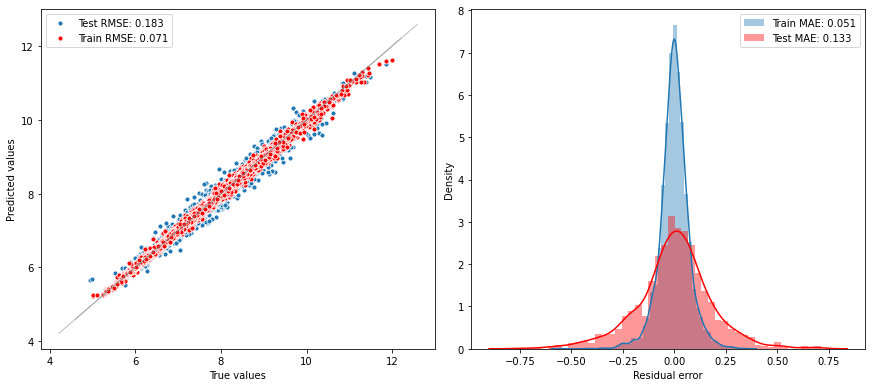

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]);
plot_adequation(y_test, y_pred, label='Test',ax=ax1, plot_line=True, score='RMSE')
plot_adequation(y_train, y_train_pred, label='Train',ax=ax1, plot_line=True, score='RMSE', color='red')

plot_residuals(y_train, y_train_pred, kind='hist', label='Train', ax=ax2, score='MAE')
plot_residuals(y_test, y_pred, kind='hist', label='Test', ax=ax2, score='MAE', color ='red')

## Uncertainty

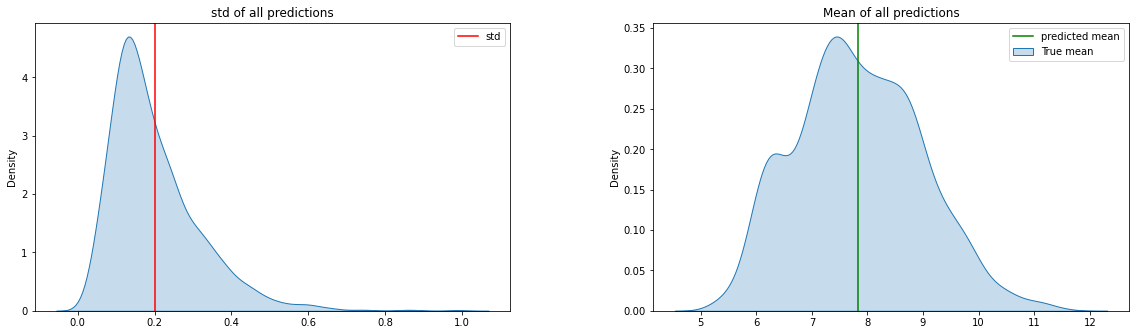

In [7]:
#get predictions before averaging
predictions = get_predictions(list_model,X_test)
predictions = predictions.reshape(len(y_test),nb_estim)

#compute std and mean 
pred_stds  = np.std(predictions, axis=1)
pred_means = np.mean(predictions,axis=1)

#plot stds and means
plt.figure(figsize=(19,5))
plt.subplot(1,2,1)
sns.kdeplot(pred_stds, shade=True)
plt.axvline(np.mean(pred_stds), color='red')
plt.title('std of all predictions')
plt.legend(['std'])

plt.subplot(1,2,2)
sns.kdeplot(pred_means, shade=True)
#plt.axvline(np.mean(p, color='red')
plt.axvline(np.mean(y_test), color='green')

plt.title('Mean of all predictions')
plt.legend(['predicted mean','True mean'])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

plt.show()

In [8]:
#Coefficient of dispersion
def dispersion(std):
    nom = np.sqrt((std - np.mean(np.array(std))**2).sum() / (len(std)-1))
    denom = np.mean(std)                 
    return nom / denom

#negative loglikelihood
#def neglog(residuals, prediction_stdv):
#    nll_list = []
#    for (res, std) in zip(residuals, prediction_stdv):
#        nll_list.append(norm.logpdf(res, scale=std))
#    nll = -1 * np.sum(nll_list)
#    return nll

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

<Figure size 1152x1008 with 0 Axes>

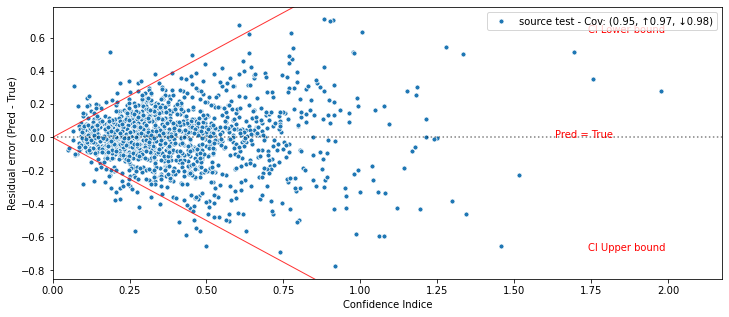

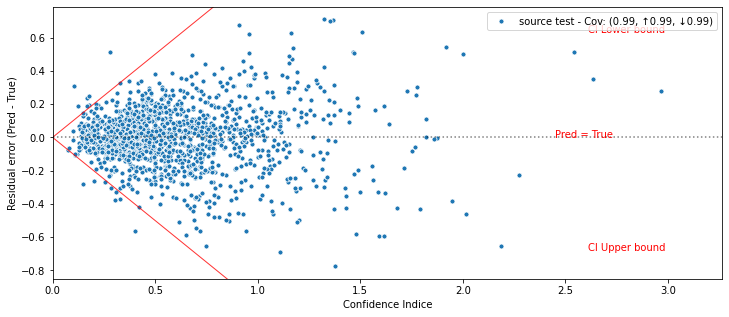

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
plot_confidence_v2(y_test,y_pred , y_pred-2*pred_stds,  y_pred+2*pred_stds, label='source test')
plot_confidence_v2(y_test,y_pred , y_pred-3*pred_stds,  y_pred+3*pred_stds,label='source test')

In [10]:
pnn_metrics = uct.metrics.get_all_metrics(np.array(pred_means), np.array(pred_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.133
  RMSE          0.183
  MDAE          0.095
  MARPD         1.690
  R2            0.975
  Correlation   0.987
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.047
  Mean-absolute Calibration Error       0.042
  Miscalibration Area                   0.043
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.072
     Group Size: 0.56 -- Calibration Error: 0.052
     Group Size: 1.00 -- Calibration Error: 0.042
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.081
     Group Size: 0.56 -- Calibration Error: 0.060
     Group Size: 1.00 -- Calibration Error: 0.047
================

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

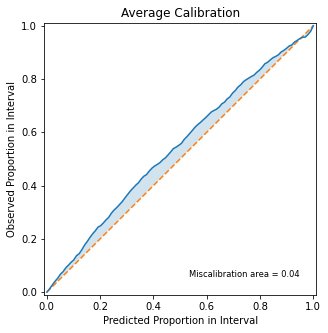

In [12]:
uct.viz.plot_calibration(np.array(pred_means),  np.array(pred_stds) , np.array(y_test))

<Figure size 720x288 with 0 Axes>

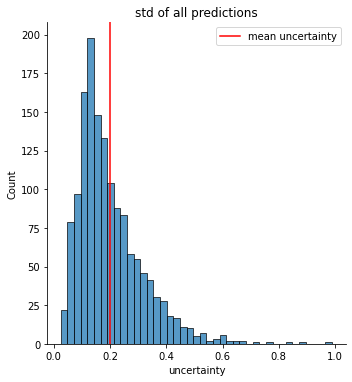

In [14]:
plt.figure(figsize=(10,4))
sns.displot(pred_stds)
plt.axvline(np.mean(pred_stds), color='red')
plt.title('std of all predictions')
plt.legend(['mean uncertainty'])
plt.xlabel('uncertainty')
plt.show()

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

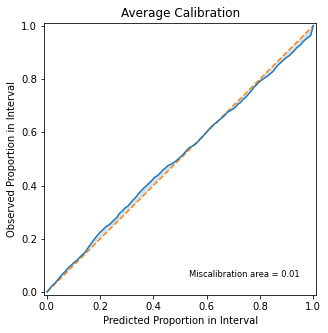

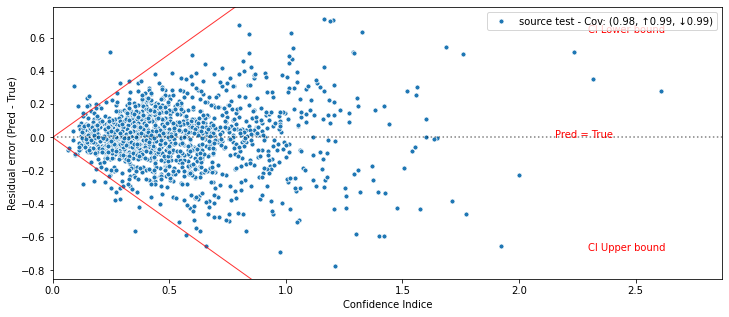

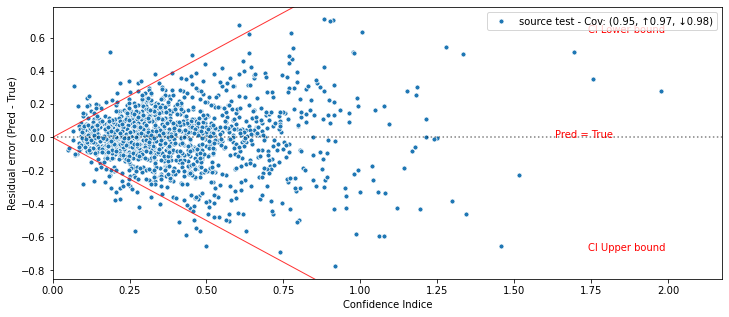

In [17]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(pred_means),  np.array(pred_stds), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(pred_stds)
uct.viz.plot_calibration(np.array(pred_means),  np.array(new_stds) , np.array(y_test))
plot_confidence_v2(y_test,np.array(pred_means) , np.array(pred_means)-3*new_stds, np.array(pred_means)+3*new_stds, label='source test')
plot_confidence_v2(y_test,y_pred , y_pred-2*pred_stds,  y_pred+2*pred_stds,label='source test')

In [19]:
all_metrics = uct.metrics.get_all_metrics(np.array(pred_means), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.133
  RMSE          0.183
  MDAE          0.095
  MARPD         1.690
  R2            0.975
  Correlation   0.987
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.016
  Mean-absolute Calibration Error       0.014
  Miscalibration Area                   0.014
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.049
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.014
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.053
     Group Size: 0.56 -- Calibration Error: 0.025
     Group Size: 1.00 -- Calibration Error: 0.016
================

## Save metrics

In [20]:
import pickle

In [21]:
with open('RandomForest_metrics_dense.pkl', 'wb') as f:
    pickle.dump(all_metrics, f)